In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
%tensorflow_version 1.x
!pip install adversarial-robustness-toolbox
#!git clone https://github.com/tensorflow/cleverhans.git
!pip install cleverhans

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
from art.attacks import PixelAttack
from art.classifiers import KerasClassifier
from art.utils import load_dataset
import random

import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.disable_eager_execution()



# Step 1: Load the CIFAR 10 dataset
(x_train_victim, y_train_victim), (x_test_victim, y_test_victim), min_, max_ = load_dataset(str("cifar10")) # Original Dataset
print("x_train_victim shape: " + str(x_train_victim.shape) + "\n" + "x_train_victim size: " + str(x_train_victim.size) + "\n" +
      "y_train_victim shape: " + str(y_train_victim.shape) + "\n" + "y_train_victim size: " + str(y_train_victim.size) + "\n" +
      "x_test_victim shape: " + str(x_test_victim.shape) + "\n" + "x_test_victim size: " + str(x_test_victim.size) + "\n" +
      "y_test_victim shape: " + str(y_test_victim.shape) + "\n" + "y_test_victim size: " + str(y_test_victim.size) + "\n")



# Step 2: Load the victim model
classifier_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"  # @param {type:"string"}
IMAGE_SHAPE = (32, 32)
victim_classifier = KerasClassifier(model=tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3,))]), clip_values=(min_, max_))



# Step 3: Evaluate the victim model on the benign dataset
predictions = victim_classifier.predict(x_test_victim)
accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_victim, axis=1)) / len(y_test_victim)
print("Accuracy on benign test examples: {}%\n".format(accuracy_benign * 100))


x_train_victim shape: (50000, 32, 32, 3)
x_train_victim size: 153600000
y_train_victim shape: (50000, 10)
y_train_victim size: 500000
x_test_victim shape: (10000, 32, 32, 3)
x_test_victim size: 30720000
y_test_victim shape: (10000, 10)
y_test_victim size: 100000



Accuracy on benign test examples: 94.52000000000001%



In [35]:
X_train_substitute = np.load('/content/gdrive/My Drive/X_synthetic.npy') 
Y_train_substitute = np.load('/content/gdrive/My Drive/Y_synthetic.npy') 
print("X_train_substitute shape: " + str(X_train_substitute.shape) + "\n" + "X_train_substitute size: " + str(X_train_substitute.size) + "\n" + 
      "Y_train_substitute shape: " + str(Y_train_substitute.shape) + "\n" + "Y_train_substitute size: " + str(Y_train_substitute.size) + "\n")
print()

X_train_substitute shape: (15000, 32, 32, 3)
X_train_substitute size: 46080000
Y_train_substitute shape: (15000, 10)
Y_train_substitute size: 150000




In [0]:
# Step 2: Create the model
model_substitute = Sequential()
model_substitute.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train_substitute.shape[1:]))
model_substitute.add(Activation("relu"))
model_substitute.add(Conv2D(32, (3, 3)))
model_substitute.add(Activation("relu"))
model_substitute.add(MaxPooling2D(pool_size=(2, 2)))
model_substitute.add(Dropout(0.25))

model_substitute.add(Conv2D(64, (3, 3), padding="same"))
model_substitute.add(Activation("relu"))
model_substitute.add(Conv2D(64, (3, 3)))
model_substitute.add(Activation("relu"))
model_substitute.add(MaxPooling2D(pool_size=(2, 2)))
model_substitute.add(Dropout(0.25))

model_substitute.add(Flatten())
model_substitute.add(Dense(512))
model_substitute.add(Activation("relu"))
model_substitute.add(Dropout(0.5))
model_substitute.add(Dense(10))
model_substitute.add(Activation("softmax"))

model_substitute.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



# Step 3: Create the classifier
substitute_classifier = KerasClassifier(model=model_substitute, clip_values=(0., 1.))

In [37]:
# Step 1: Load the subset data
X = np.load('/content/gdrive/My Drive/X_subset.npy') 
Y = np.load('/content/gdrive/My Drive/Y_subset.npy') 
print("X shape: " + str(X.shape) + "\n" + "X size: " + str(X.size) + "\n" + 
      "Y shape: " + str(Y.shape) + "\n" + "Y size: " + str(Y.size) + "\n")
print()

X_test_substitute = X[7500:]
Y_test_substitute = Y[7500:]
print("X_test_substitute shape: " + str(X_test_substitute.shape) + "\n" + "X_test_substitute size: " + str(X_test_substitute.size) + "\n" + 
      "Y_test_substitute shape: " + str(Y_test_substitute.shape) + "\n" + "Y_test_substitute size: " + str(Y_test_substitute.size) + "\n")
print()

X shape: (10000, 32, 32, 3)
X size: 30720000
Y shape: (10000, 10)
Y size: 100000


X_test_substitute shape: (2500, 32, 32, 3)
X_test_substitute size: 7680000
Y_test_substitute shape: (2500, 10)
Y_test_substitute size: 25000




In [38]:
#Step 4: Evaluate the ART classifier on benign test examples
predictions = substitute_classifier.predict(X_test_substitute)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test_substitute, axis=1)) / len(Y_test_substitute)
print("Accuracy on benign test examples for substitute classifier: {}%".format(accuracy * 100))

Accuracy on benign test examples for substitute classifier: 10.16%


     |████████████████████████████████| 235kB 40.1MB/s 



Accuracy on benign test examples: 94.52000000000001%
Average Accuracy on adversarial test examples with eps = 0.05: 10.4%
Average Accuracy on adversarial test examples with eps = 0.1: 10.3%
Average Accuracy on adversarial test examples with eps = 0.5: 10.4%
Average Accuracy on adversarial test examples with eps = 0.95: 10.2%

Classifier with benign example has Airplane recognition average accuracy of = 100%
Fast Gradient Method with eps = 0.05 has Airplane recognition average accuracy of = 1%
Fast Gradient Method with eps = 0.10 has Airplane recognition average accuracy of = 2%
Fast Gradient Method with eps = 0.50 has Airplane recognition average accuracy of = 3%
Fast Gradient Method with eps = 0.95 has Airplane recognition average accuracy of = 2%

Classifier with benign example has Automobile recognition average accuracy of = 100%
Fast Gradient Method with eps = 0.05 has Automobile recognition average accuracy of = 99%
Fast Gradient Method with eps = 0.10 has Automobile recognition 

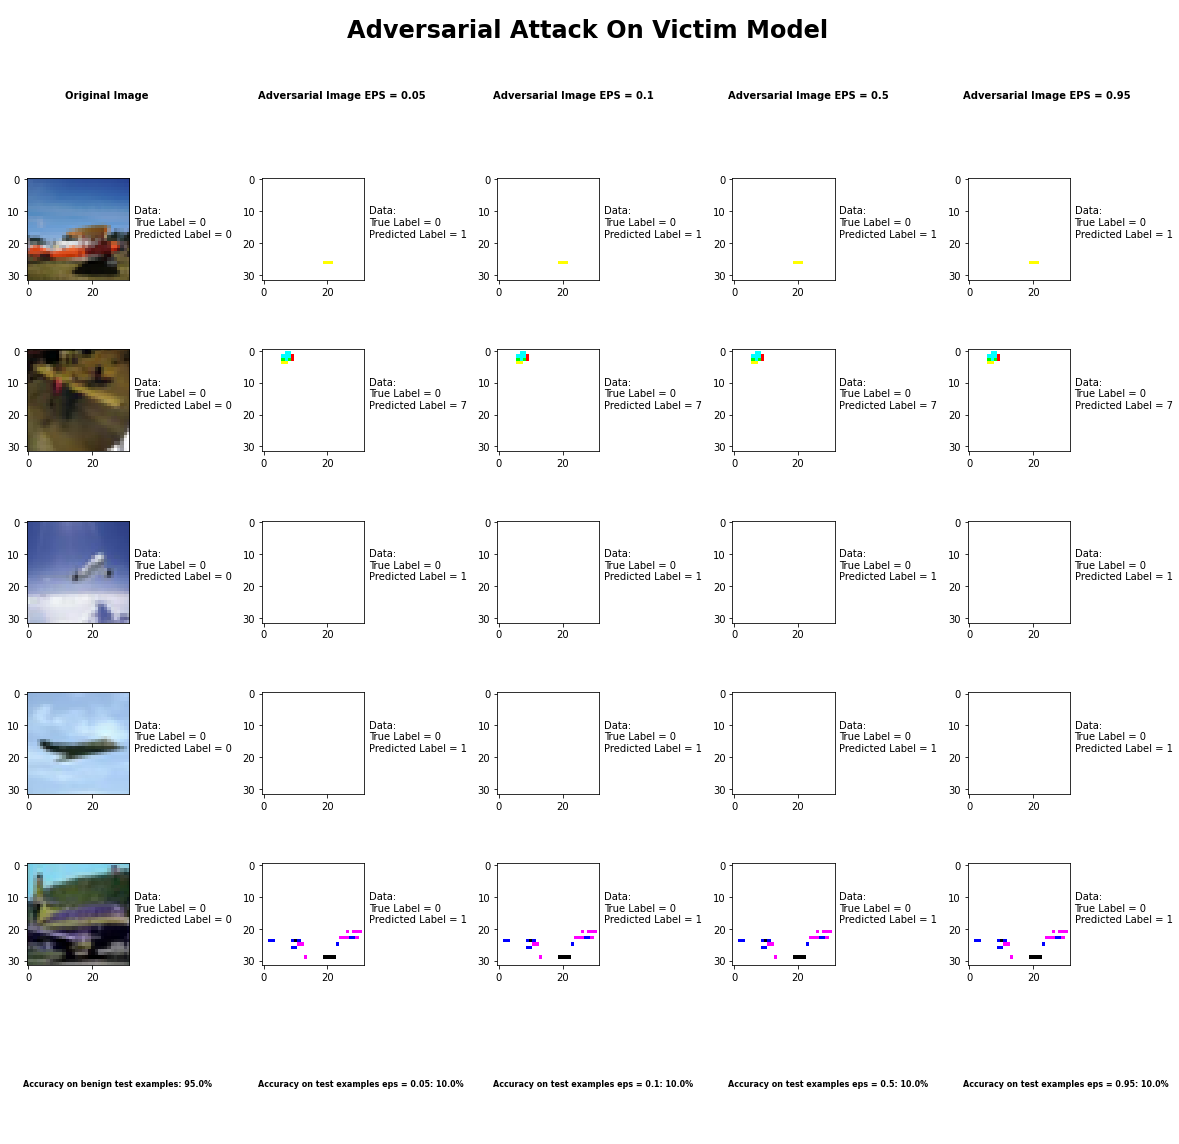

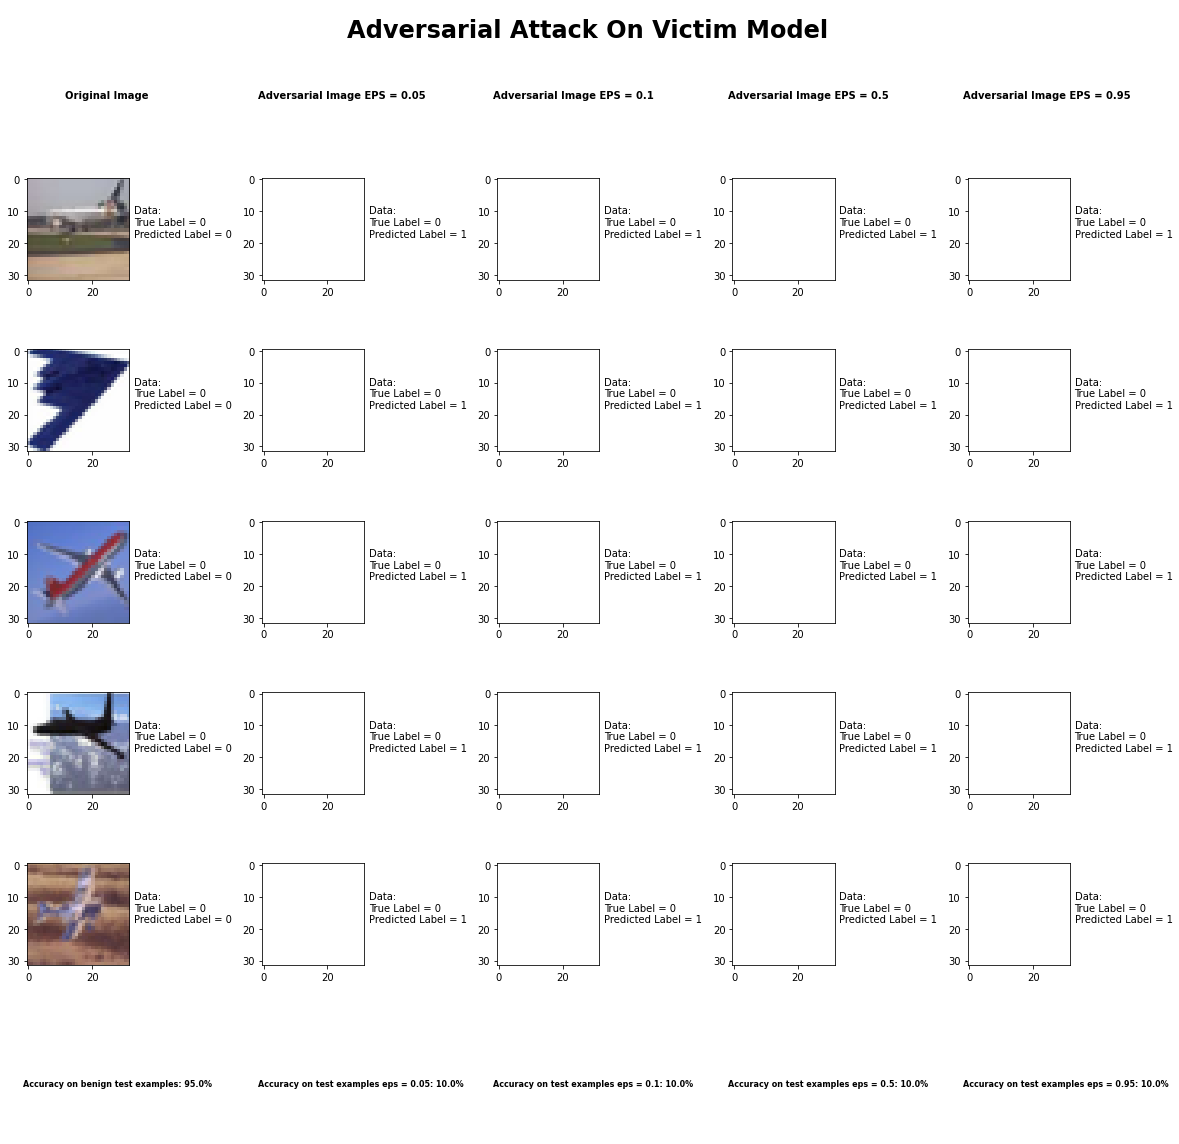

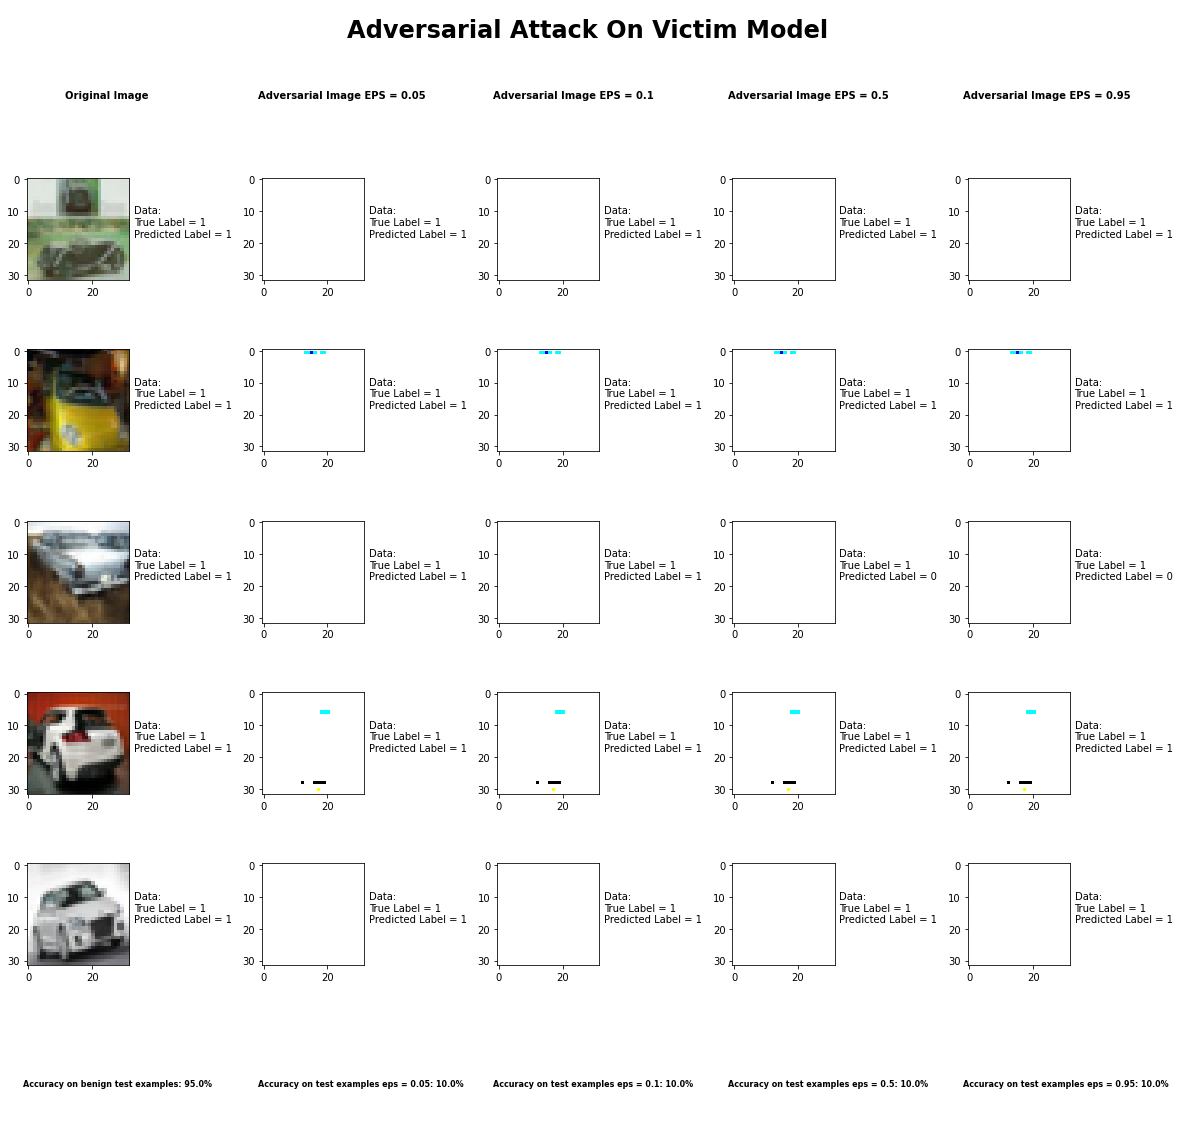

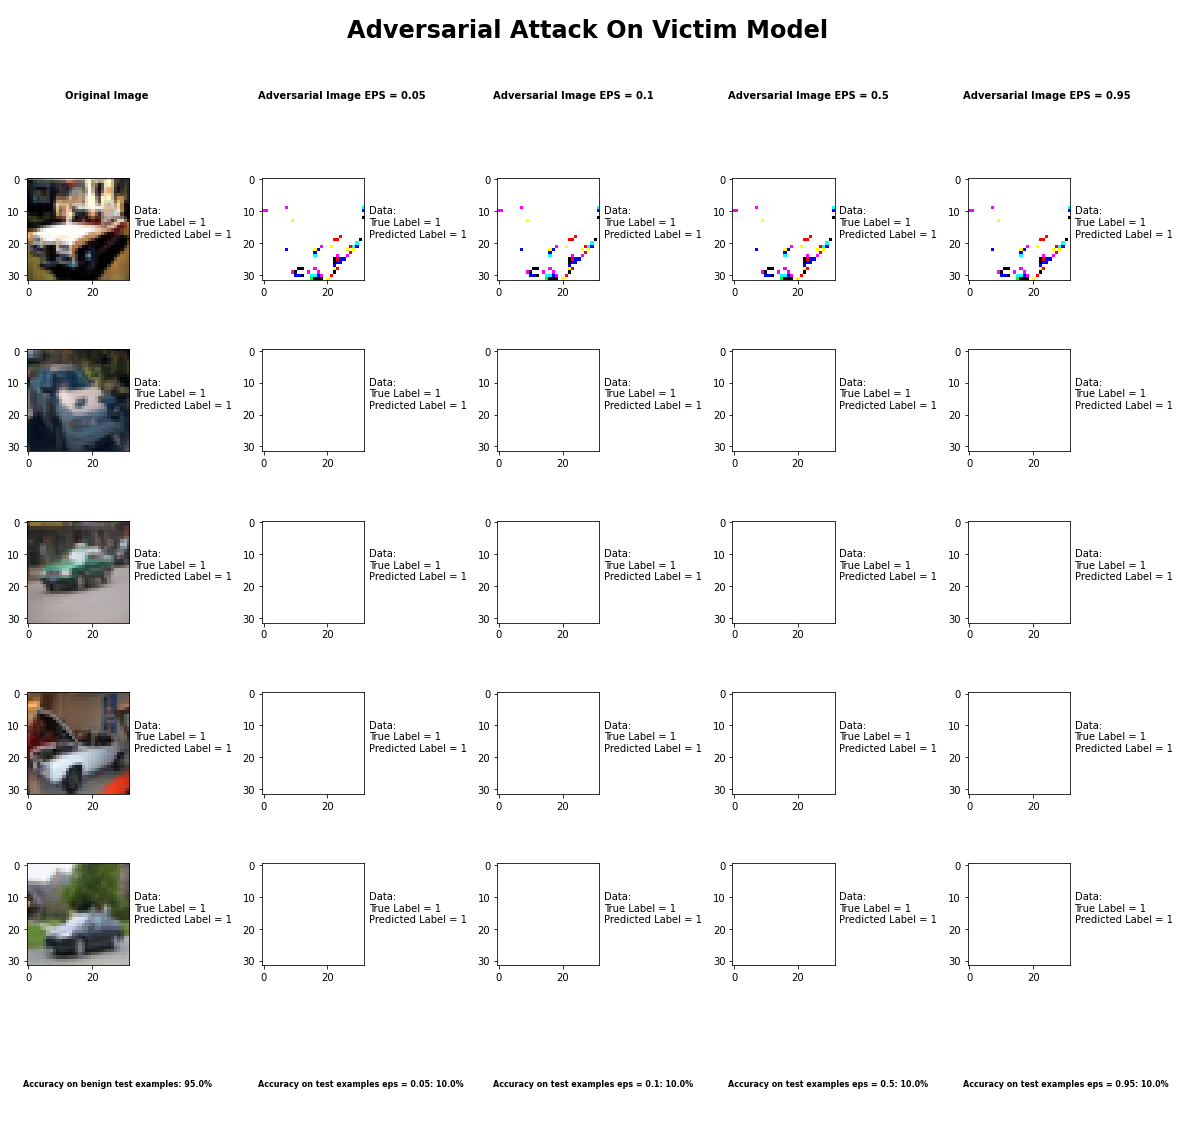

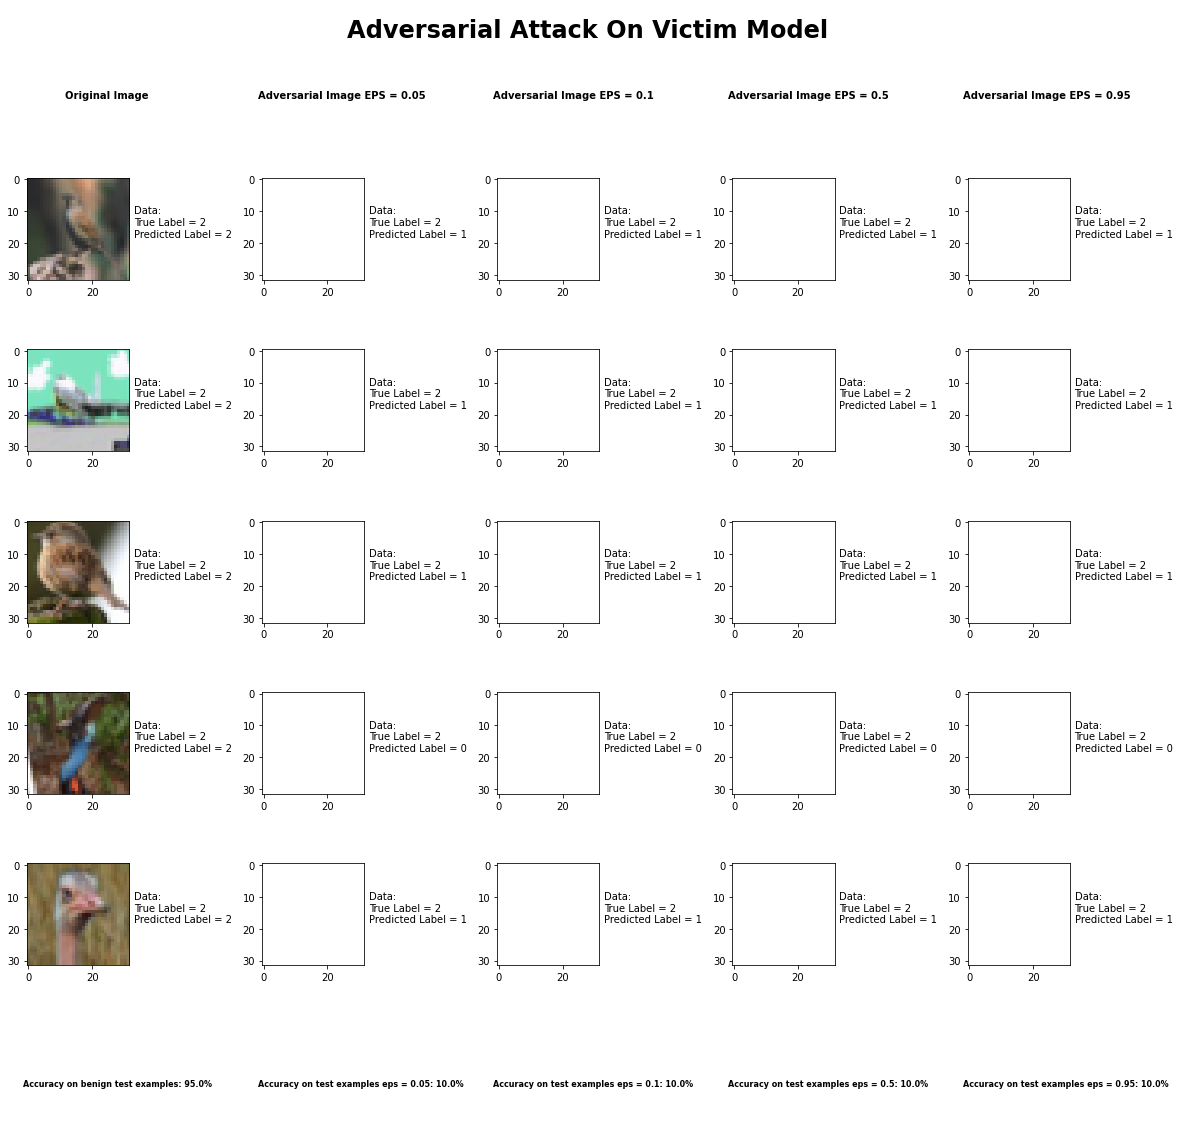

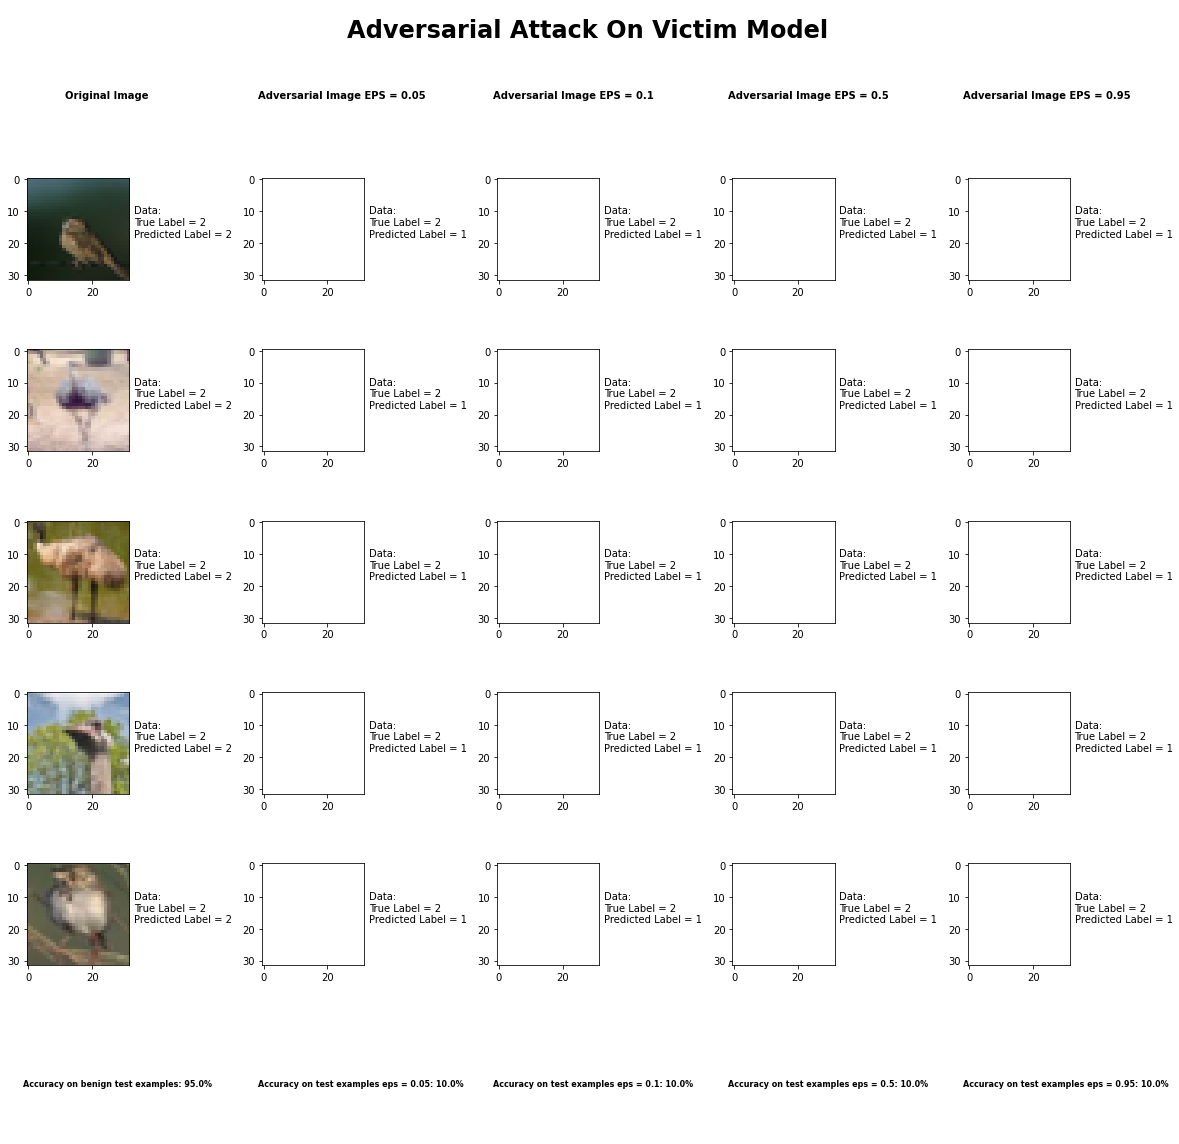

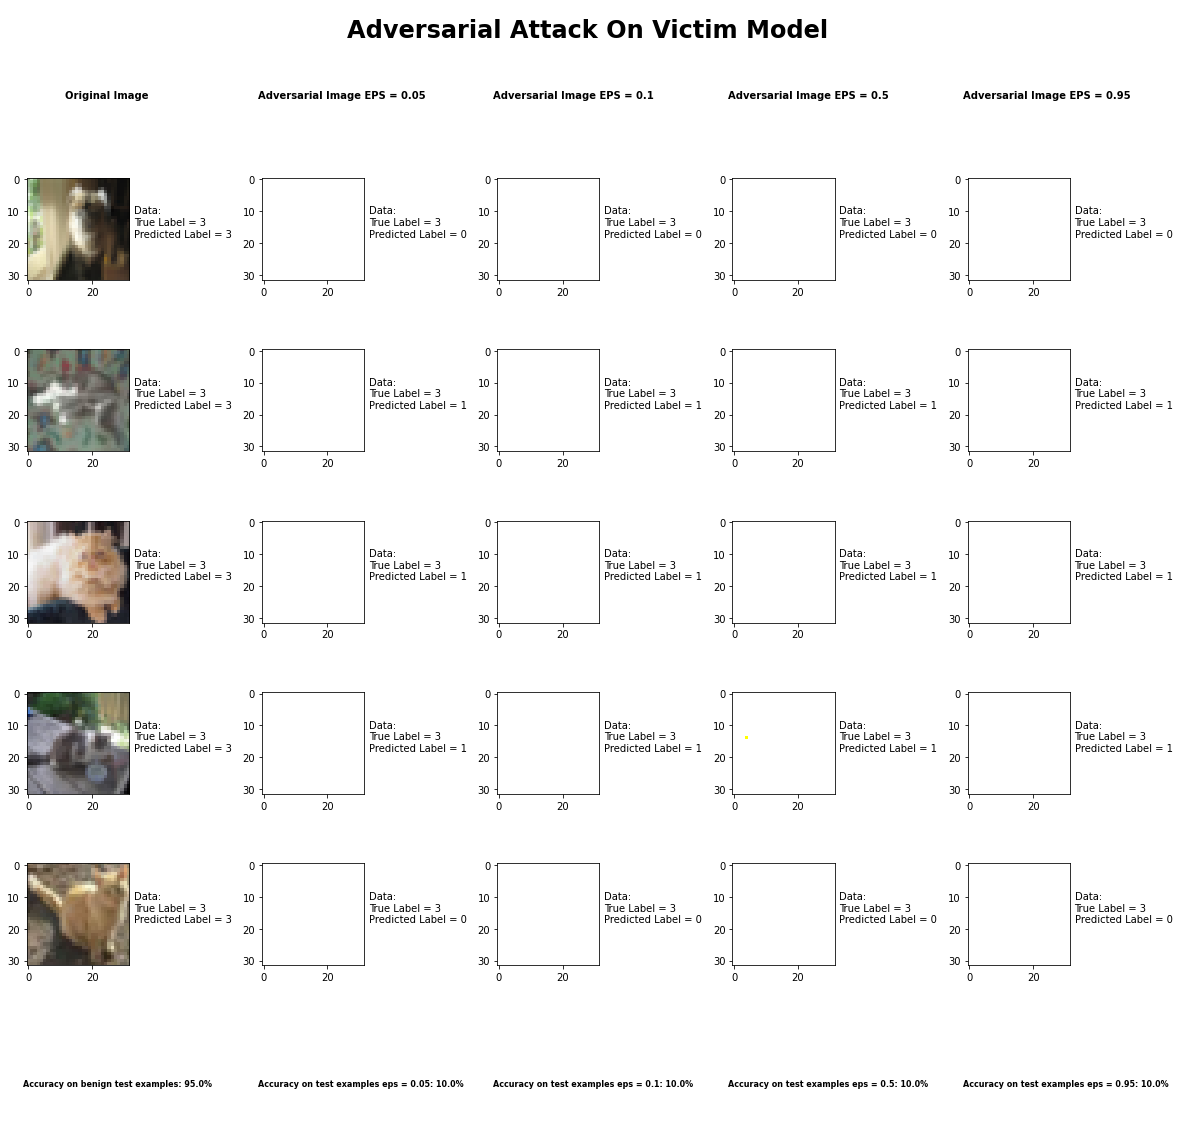

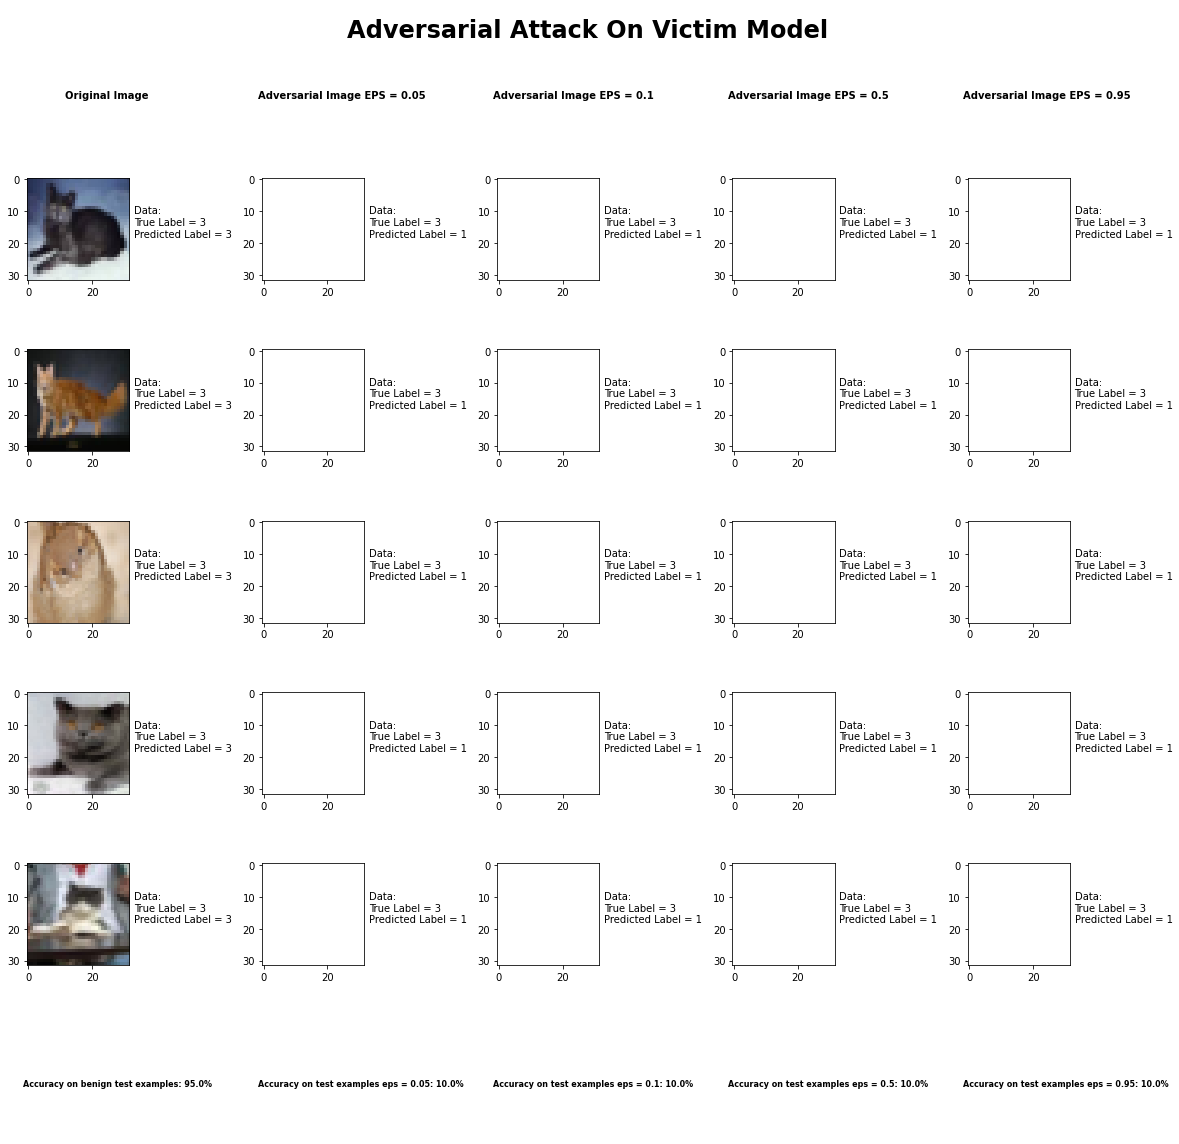

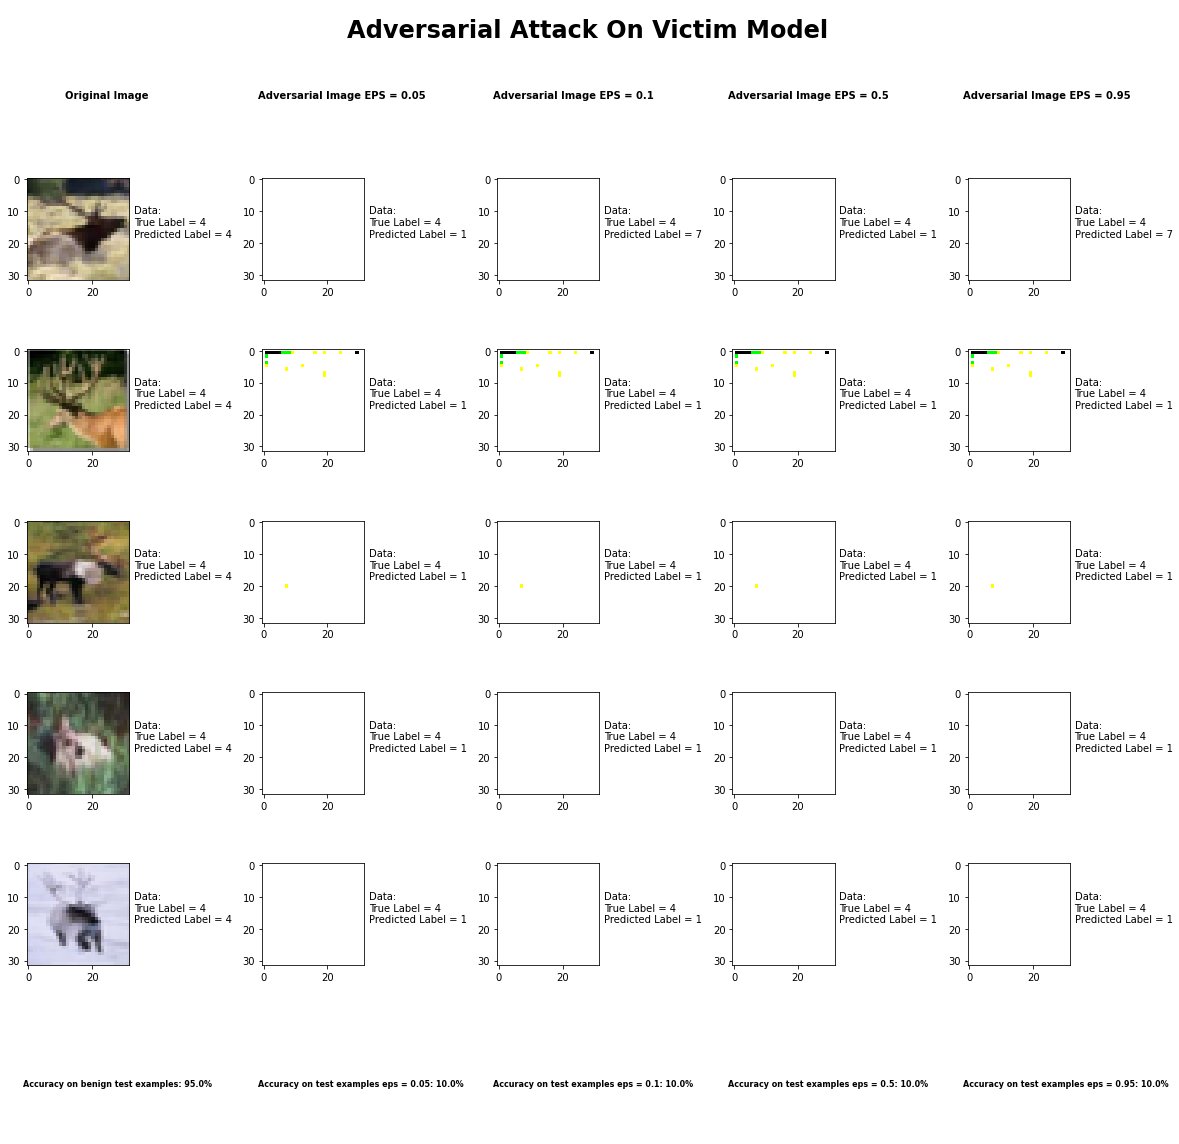

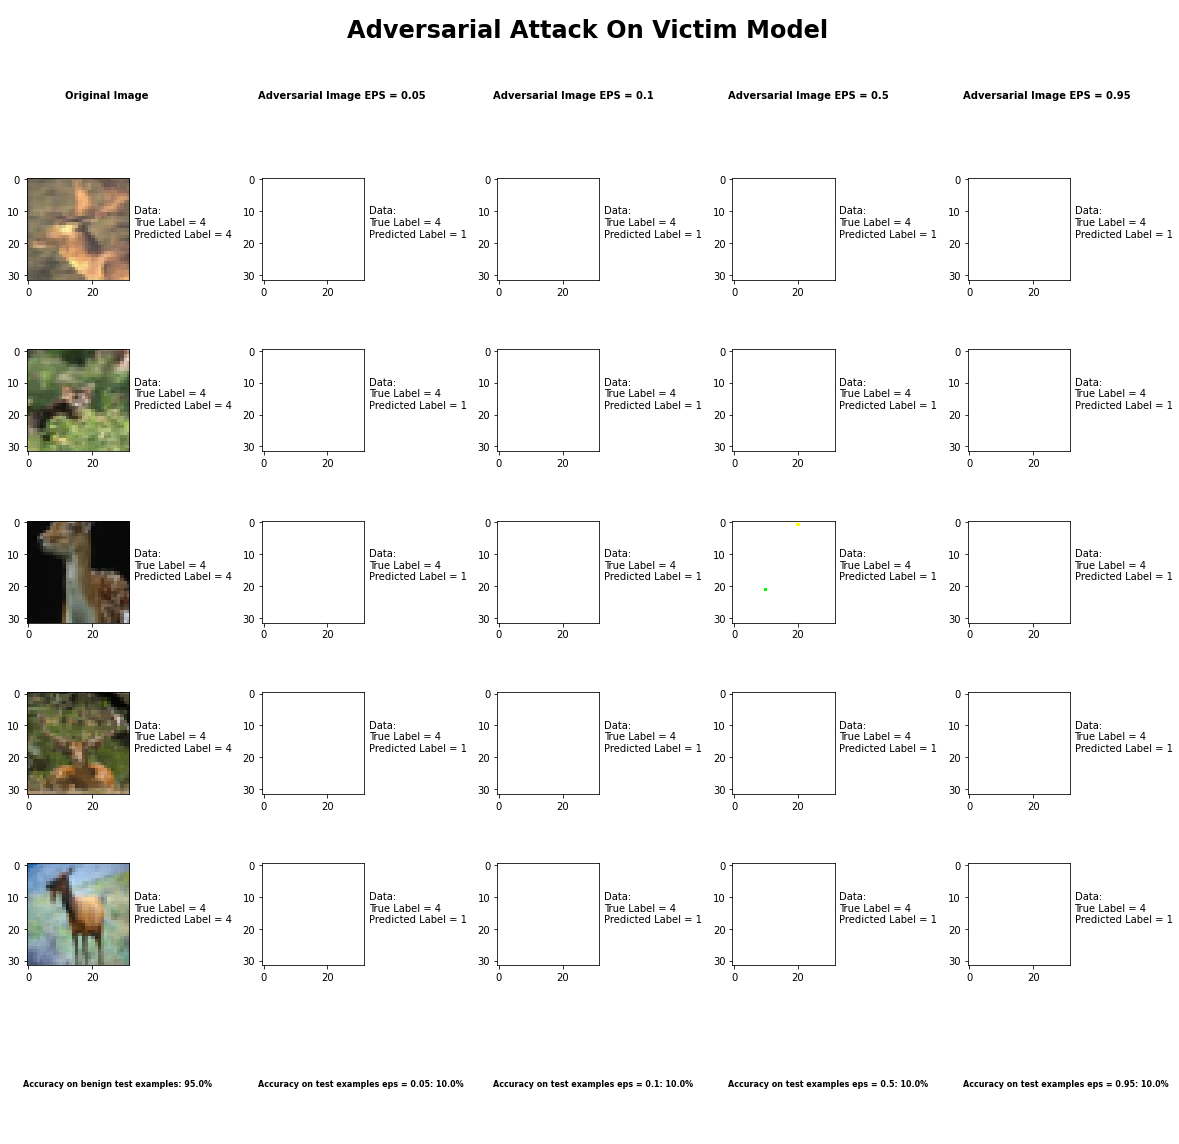

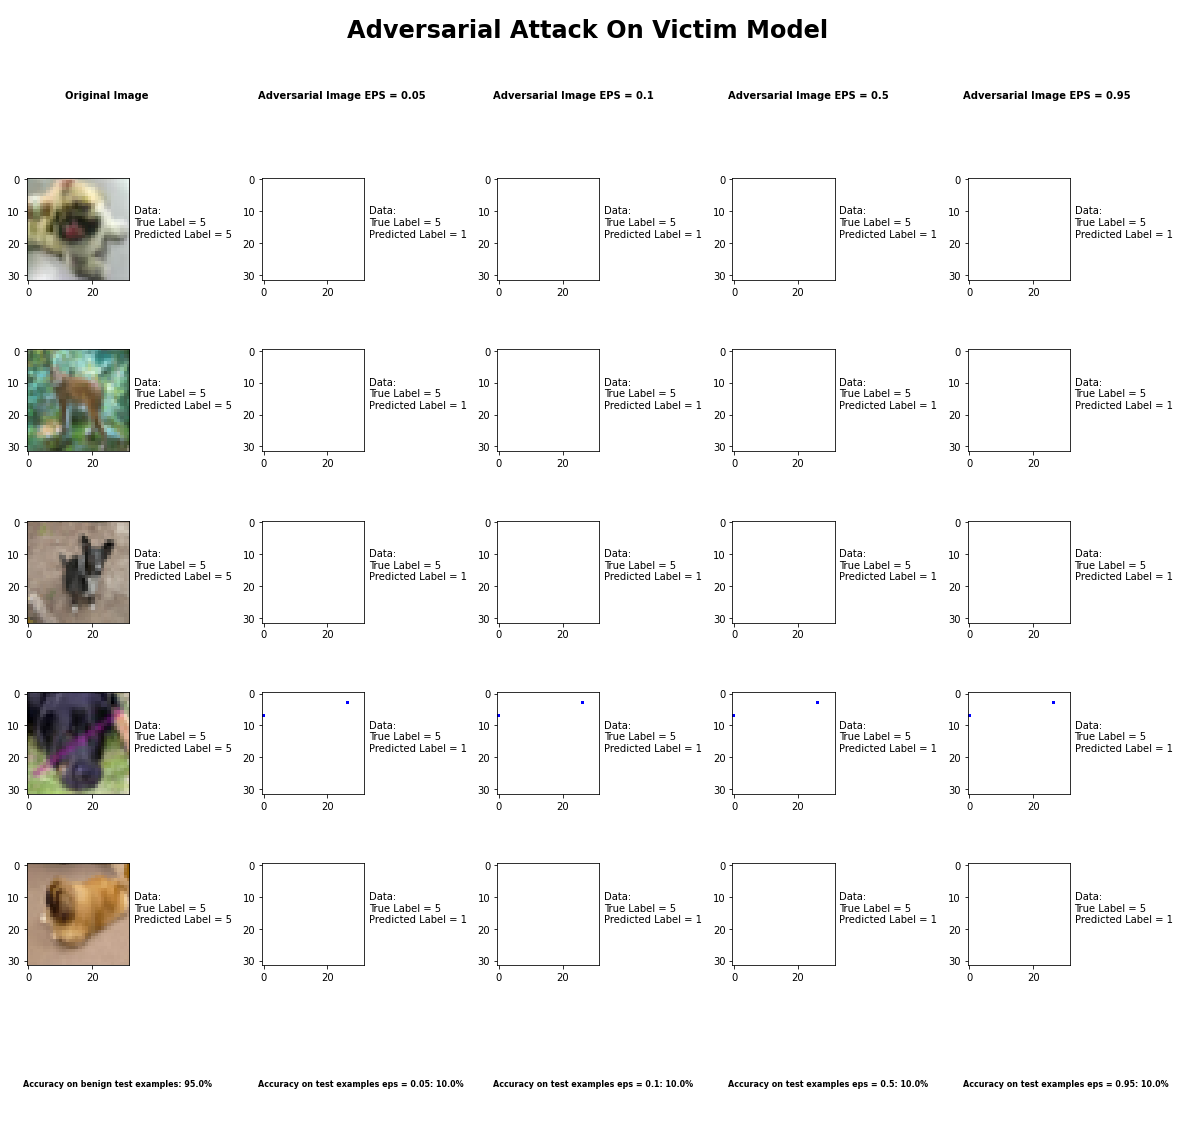

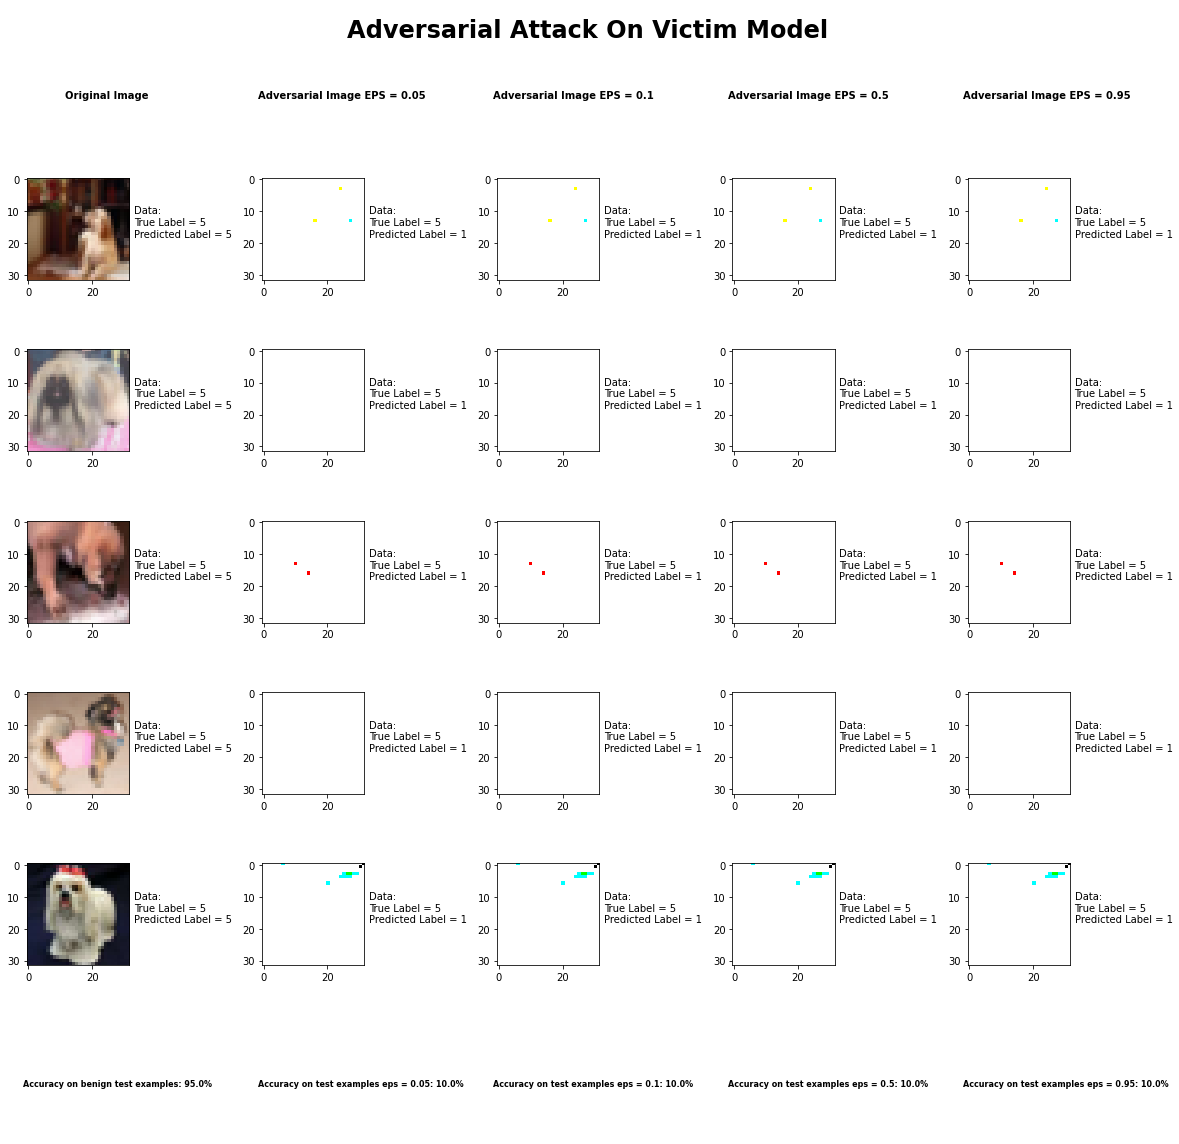

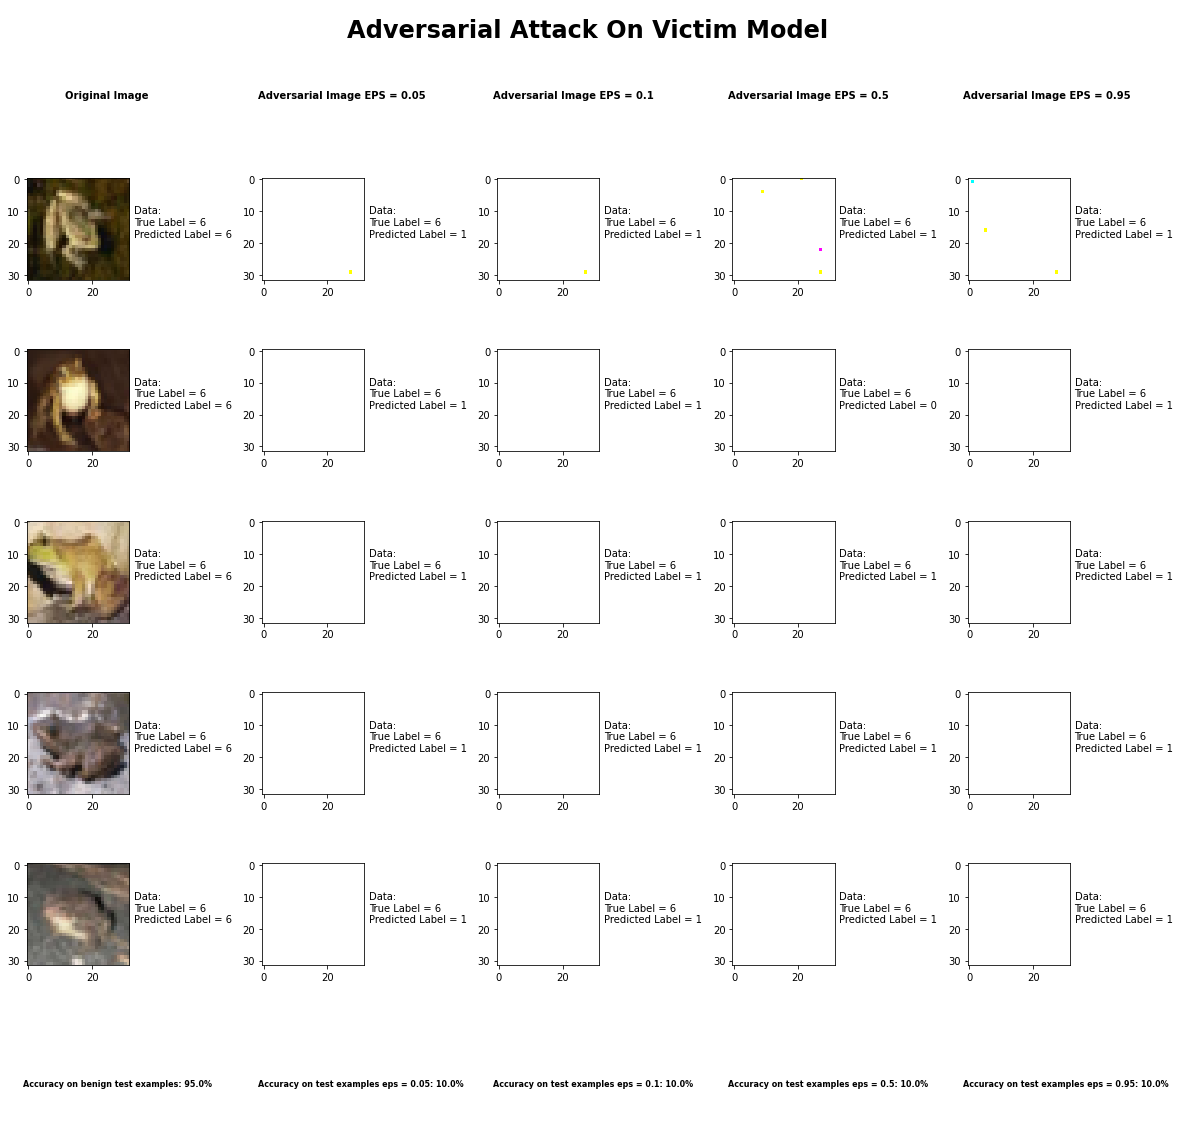

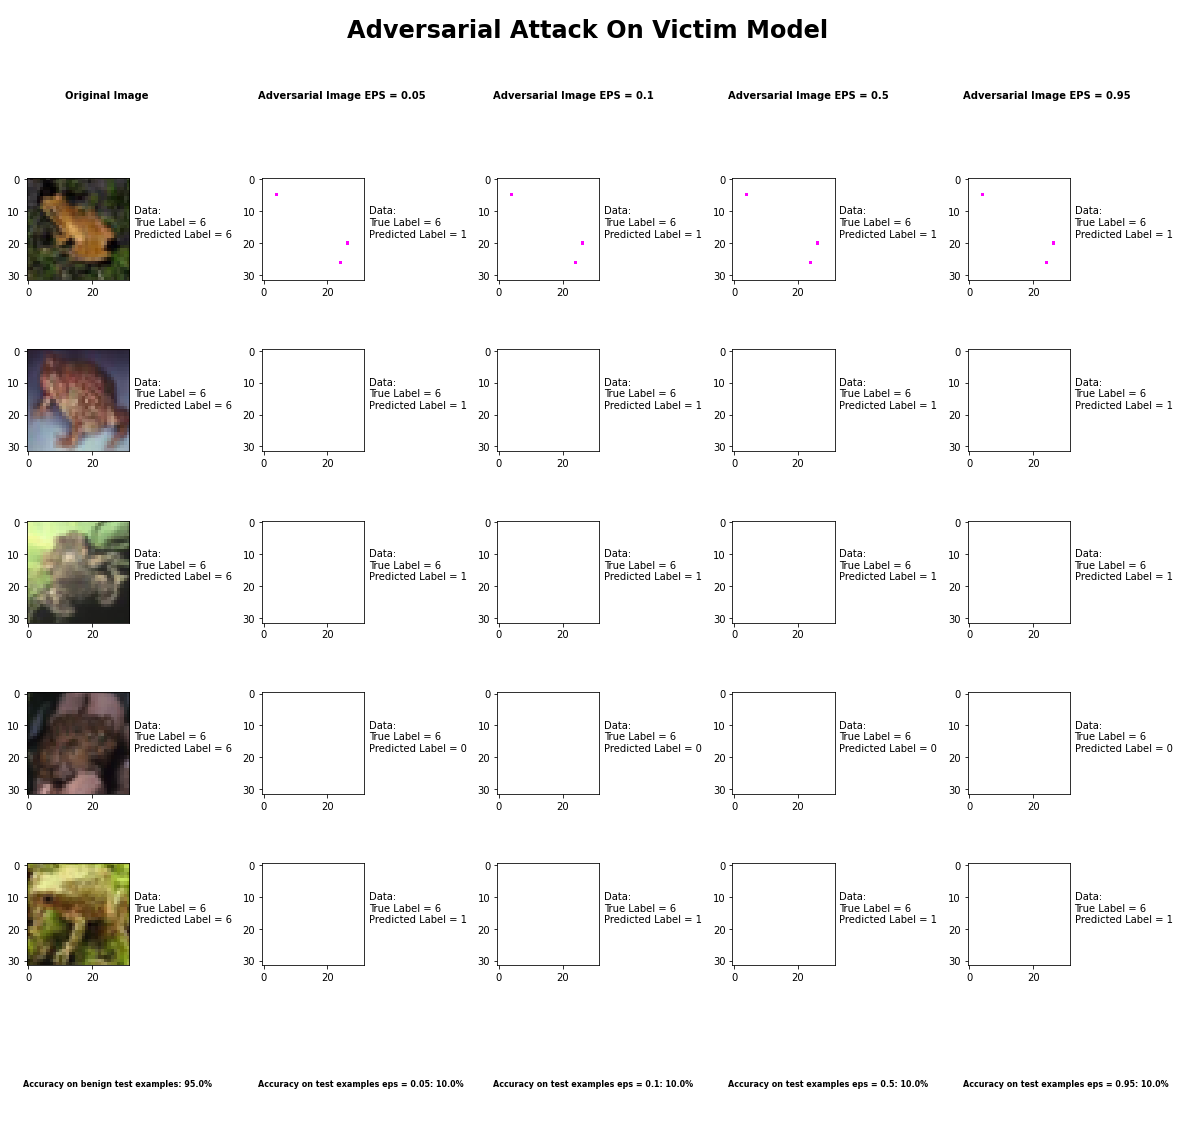

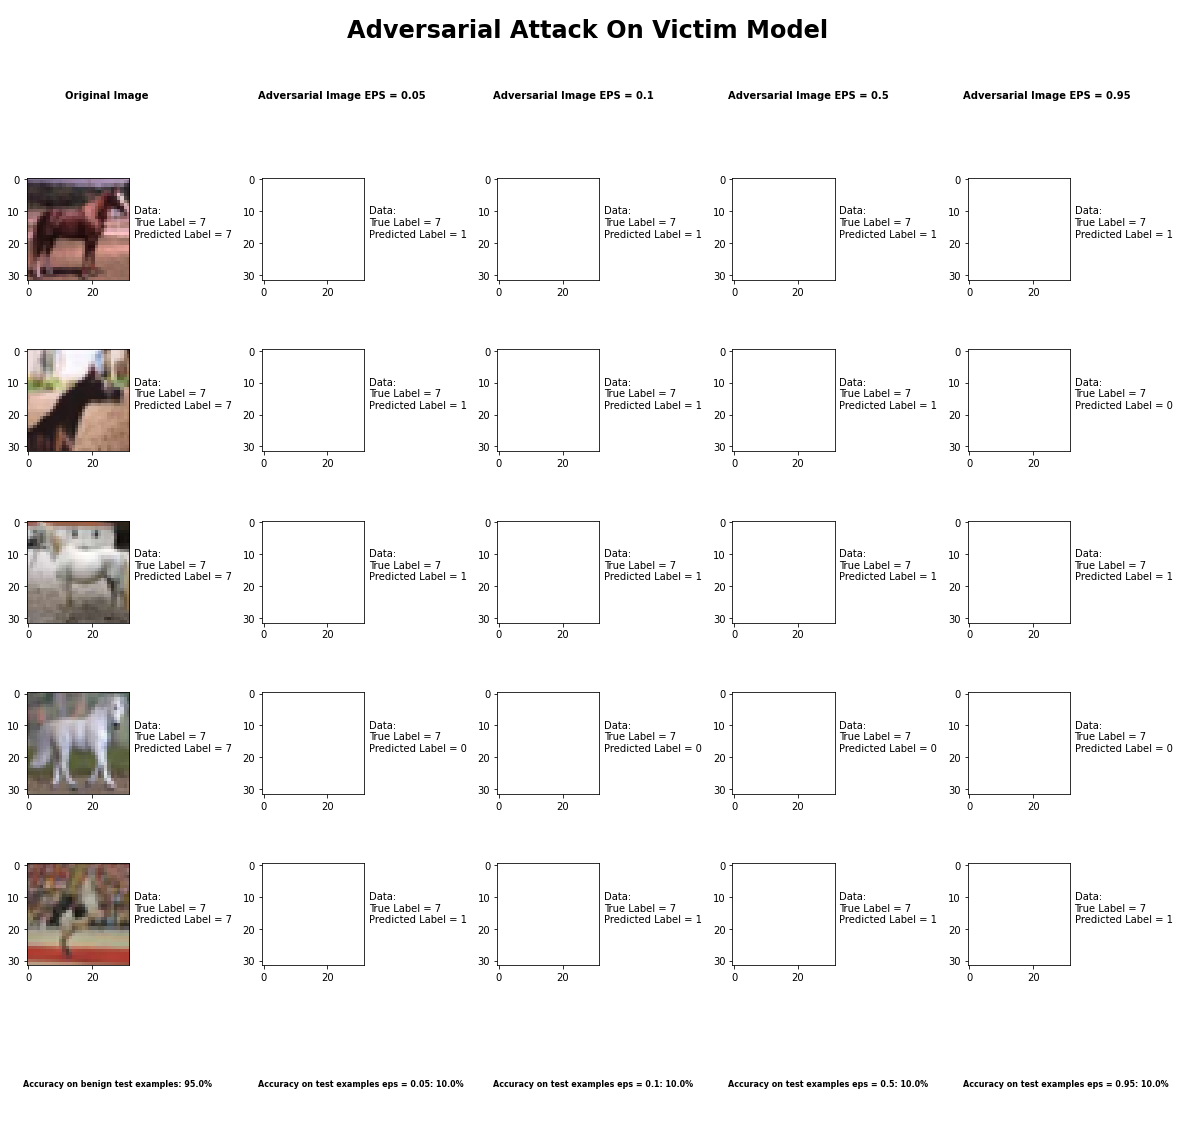

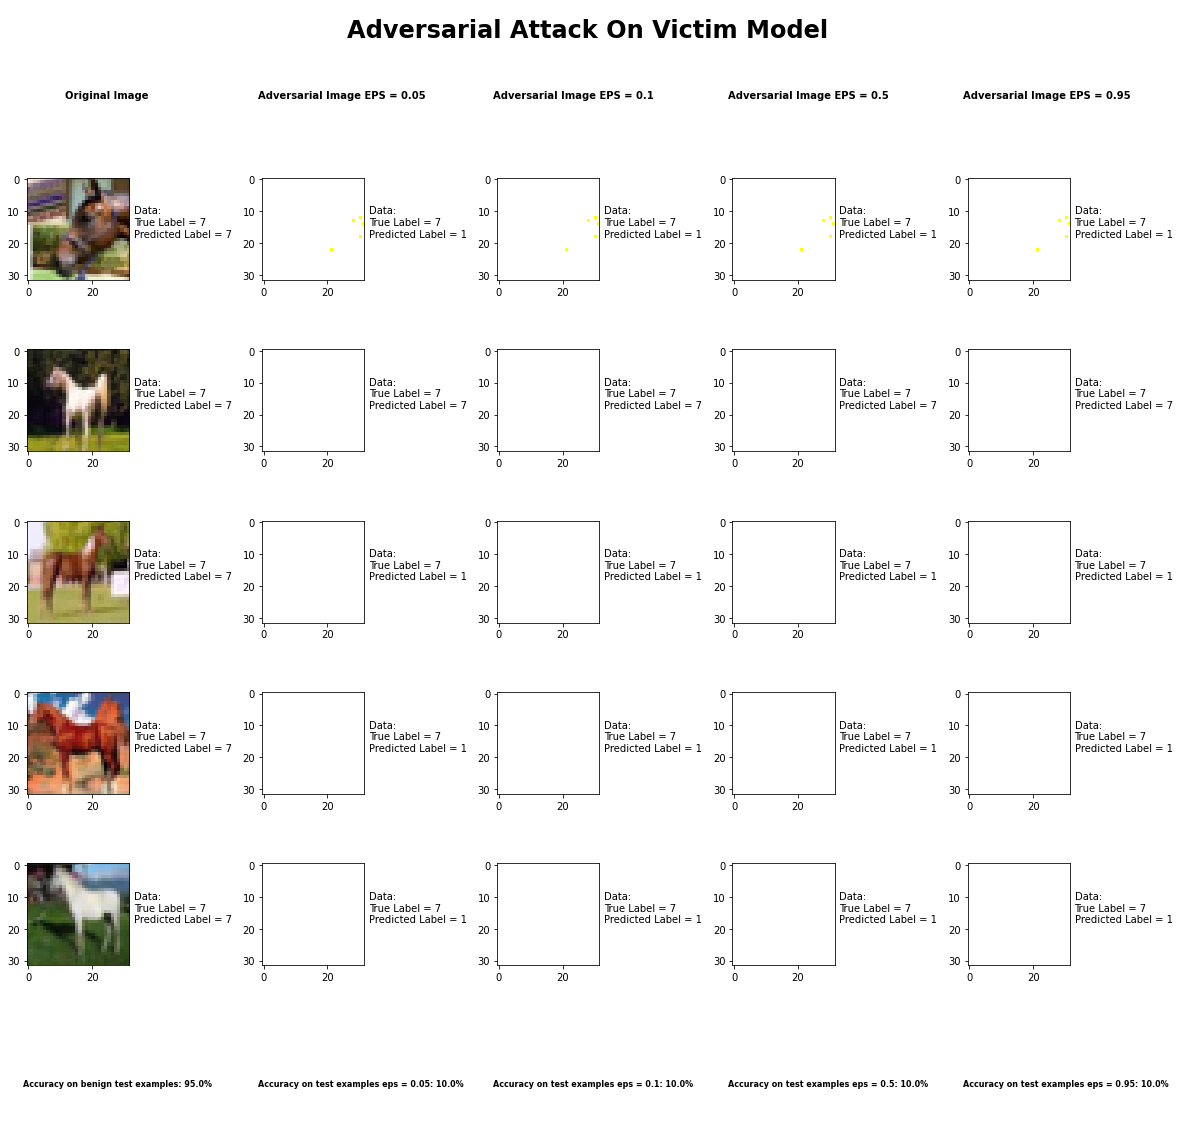

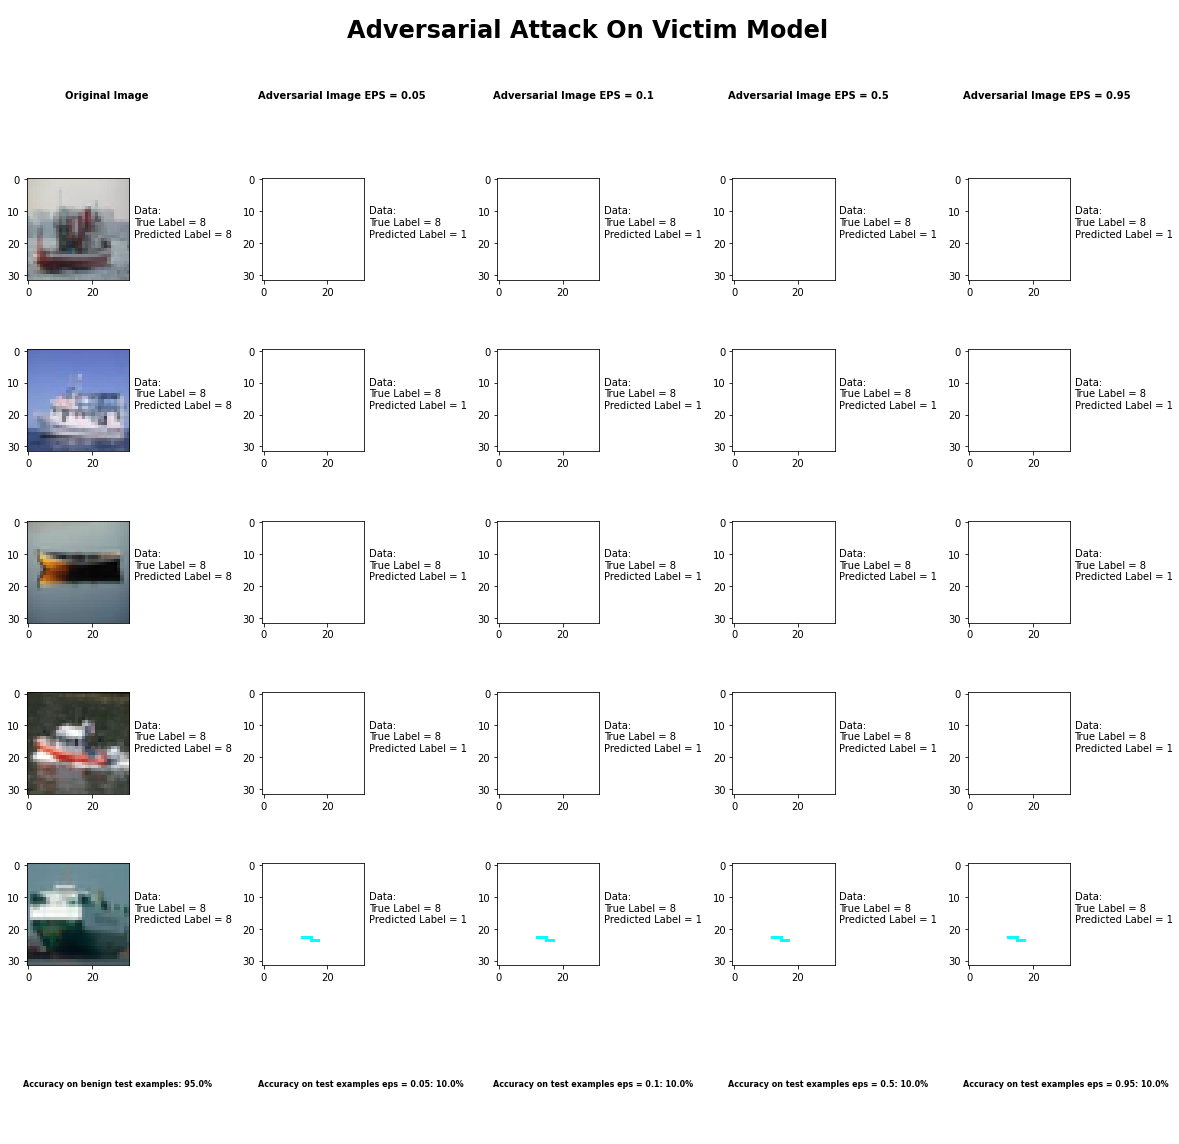

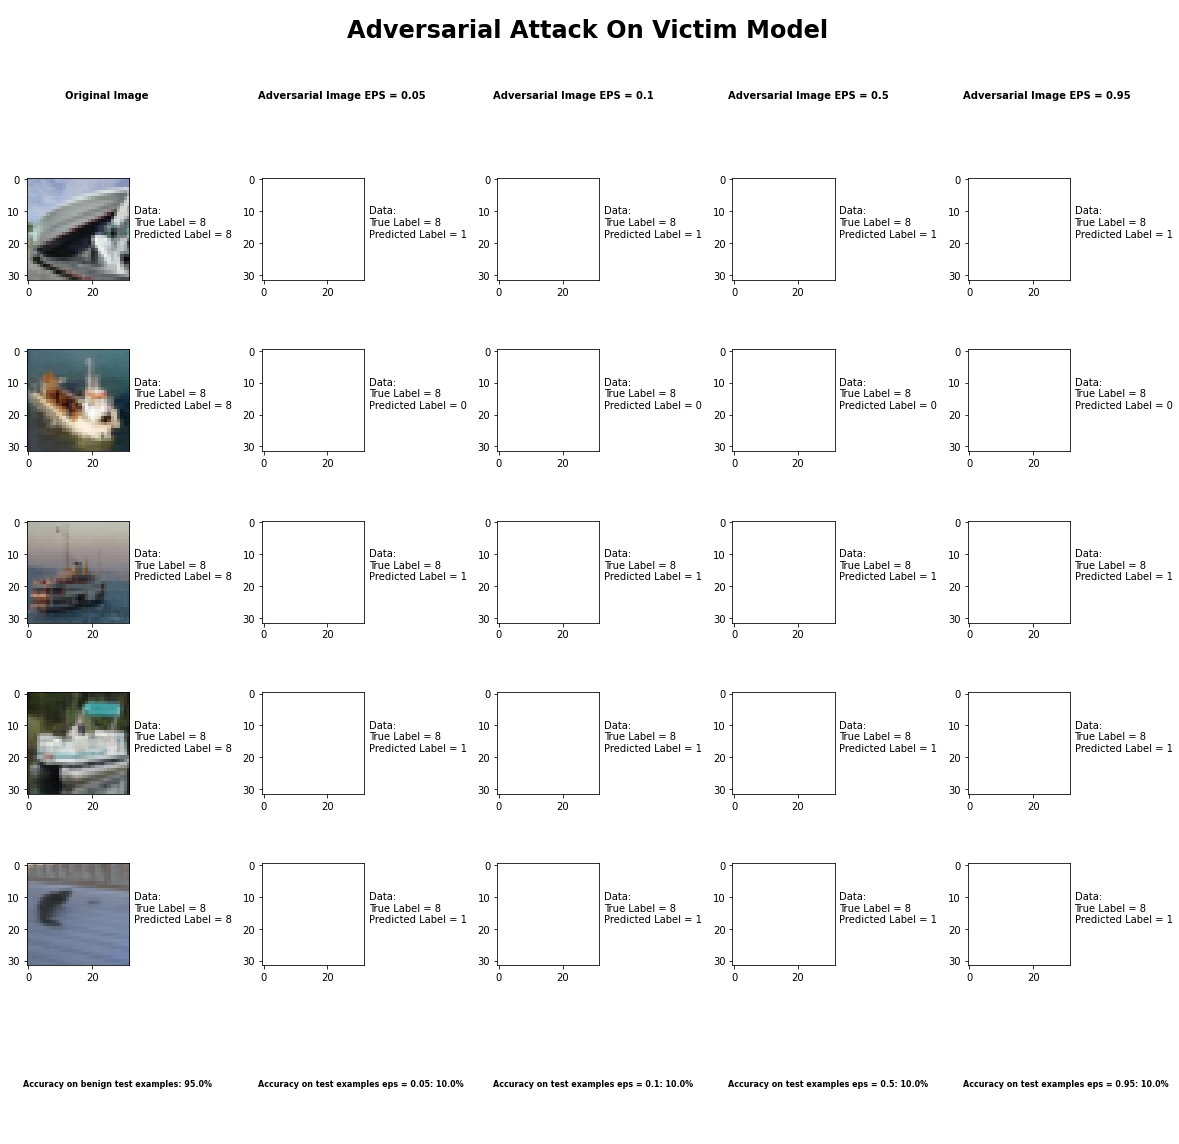

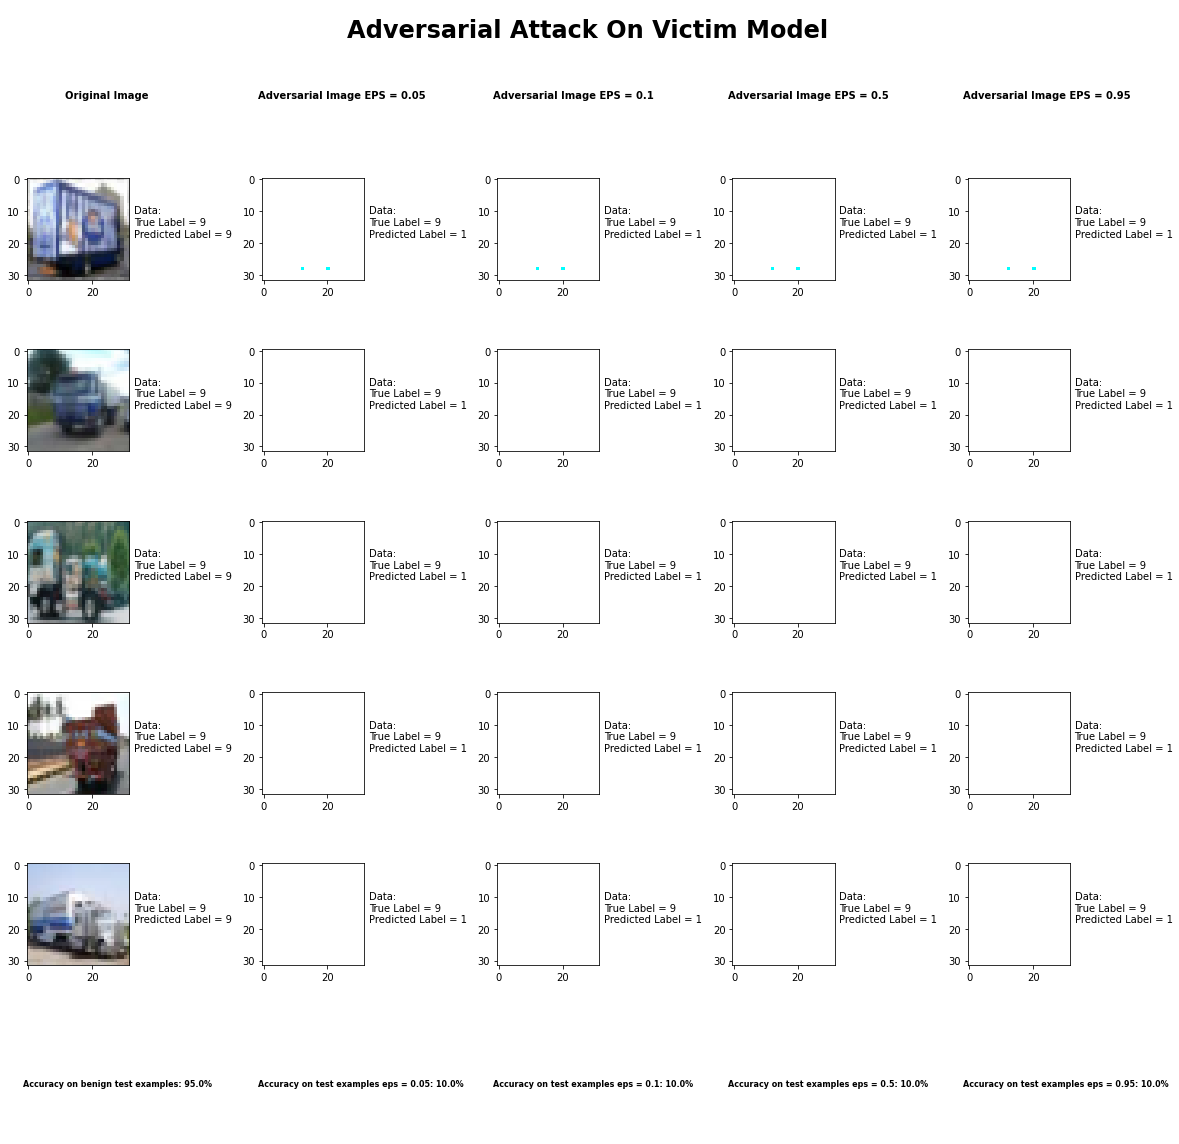

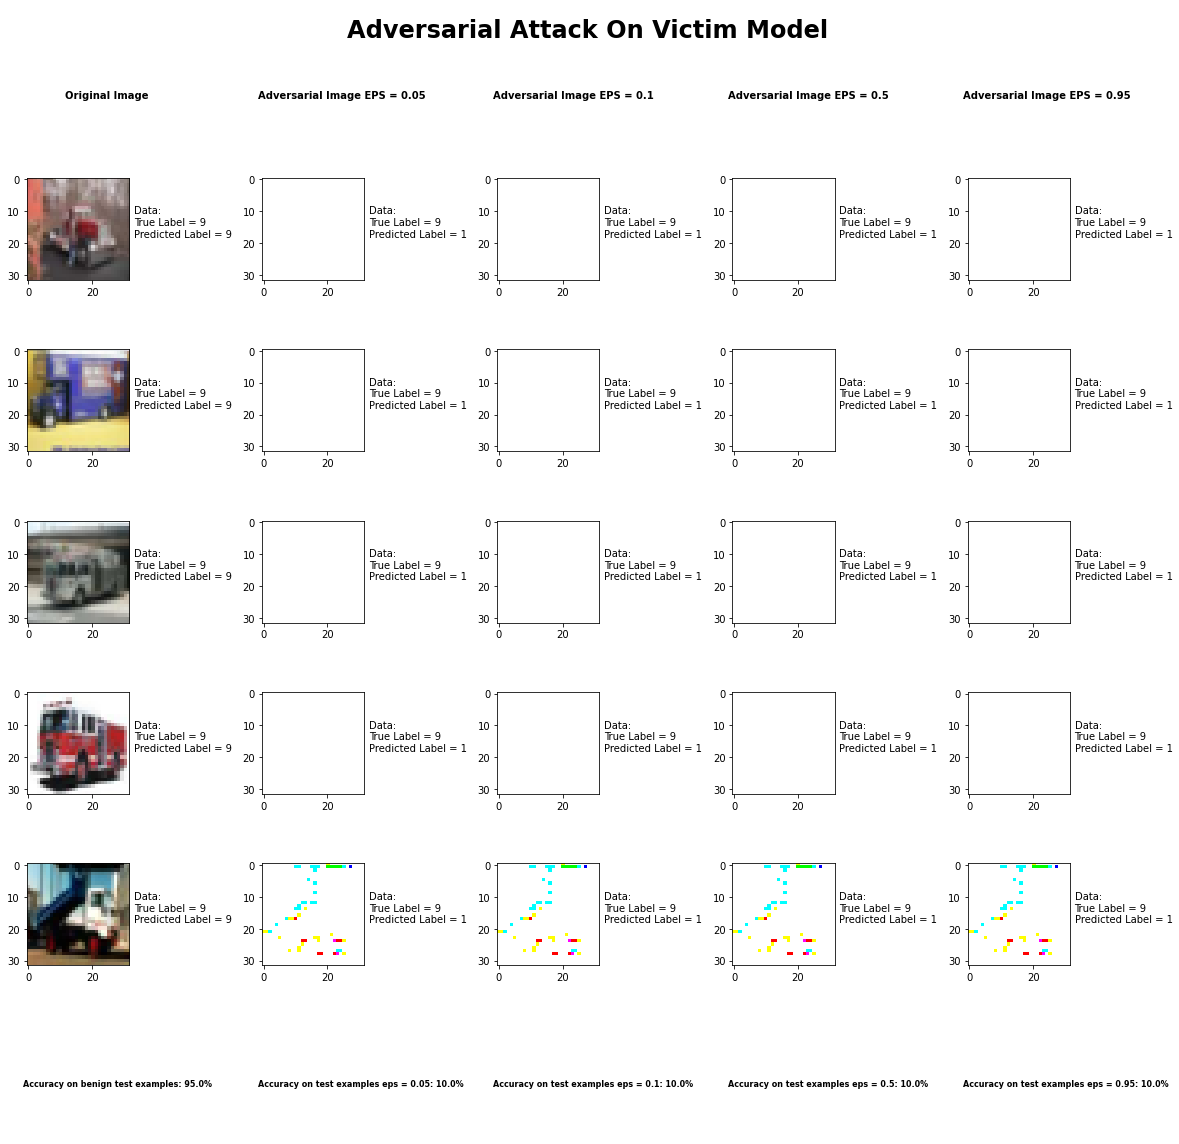

In [41]:
# Step 4 and 5
!pip install cma
def getaccuracy_forone_extraction(x_test, y_test):
    # Step 4: Collect 10 instances of each case from test examples
    def exract_ten_classes( data, labels, classes=(0,1,2,3,4,5,6,7,8,9), no_instance=10 ):
        x_pre = [] # list to collect the x_test set
        y_pre = [] # list to collect the y_test set
        for class_label in range(0, 10): # loop through each of the classes
            index = random.randint(0, 1250) # randomly choose an index from the x_test, as means of getting different instances from each class
            iteration = no_instance # number of instance of each class to collect
            while (iteration != 0):
                if np.argmax(labels[index]) == classes[class_label]: # check if the current index label matches the specified class label we are looking for
                    x_pre.append(data[index]) # add the image to the x_test set
                    y_pre.append(int(class_label)) # add the image label to the y_test set
                    iteration = iteration - 1 # reduce # of instances by 1
                index = index + 1 # go to next index till next label is of the current class
        x = np.asarray(x_pre)  # append all 100, 10 of each class, images together
        y = keras.utils.to_categorical( np.asarray(y_pre), 10)  # append all 100, 10 of each class, labels together and do one hot encoding
        return x, y

    x_test_adv_pre, y_test_adv = exract_ten_classes( X_test_substitute, Y_test_substitute ) # call method to get 10 instances of each class
    #print("x_test_adv_pre shape: " + str(x_test_adv_pre.shape) + "\n" + "x_test_adv_pre size: " + str(x_test_adv_pre.size) + "\n" +
     #     "y_test_adv_pre shape: " + str(y_test_adv.shape) + "\n" + "y_test_adv_pre size: " + str(y_test_adv.size) + "\n")


    # Step 5: Generate adversarial test examples and Evaluate the ART classifier on adversarial test examples
    attack_eps_5 = PixelAttack(classifier=substitute_classifier, th=1)
    x_test_adv_eps_5 = attack_eps_5.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_5 = victim_classifier.predict(x_test_adv_eps_5) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_5 = np.sum(np.argmax(predictions_eps_5, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.05: {}%".format(accuracy_adv_eps_5 * 100))

    attack_eps_10 = PixelAttack(classifier=substitute_classifier, th=5)
    x_test_adv_eps_10 = attack_eps_10.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_10 = victim_classifier.predict(x_test_adv_eps_10) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_10 = np.sum(np.argmax(predictions_eps_10, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.1: {}%".format(accuracy_adv_eps_10 * 100))

    attack_eps_50 = PixelAttack(classifier=substitute_classifier, th=10)
    x_test_adv_eps_50 = attack_eps_50.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_50 = victim_classifier.predict(x_test_adv_eps_50) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_50 = np.sum(np.argmax(predictions_eps_50, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.5: {}%".format(accuracy_adv_eps_50 * 100))

    attack_eps_95 = PixelAttack(classifier=substitute_classifier, th=15)
    x_test_adv_eps_95 = attack_eps_95.generate(x=x_test_adv_pre) # generate adversarial examples from the x_test_adv which has 100 examples of 10 images per class
    predictions_eps_95 = victim_classifier.predict(x_test_adv_eps_95) # feed the adversarial examples to the classifier and predict the labels
    accuracy_adv_eps_95 = np.sum(np.argmax(predictions_eps_95, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calcualte the classifiers accuracy
    #print("Accuracy on adversarial test examples with eps = 0.95: {}%".format(accuracy_adv_eps_95 * 100))

    accuracies = [accuracy_adv_eps_5 * 100, accuracy_adv_eps_10 * 100, accuracy_adv_eps_50 * 100, accuracy_adv_eps_95 * 100] # create a list which holds the accuracy of the classifier with differnt values of epsilon for the FGSM attack

    all_count = [] # used to hold the accuracy of each attack on each label, i.e. original, eps = 5, eps 10, eps = 50, eps = 95
    for j in range(0, 100, 10): # iterate through each class
        count = [0, 0, 0, 0, 0] # used to hold accuracy of each attack for this instance of the label
        for i in range(j, j + 10): # loop through each instance of the current class
            sample_pre = x_test_adv_pre[i, :] # load the current image from the x set
            label_pre = np.argmax(victim_classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2])))) # predict the label of the original image from x set
            sample_post_eps_5 = x_test_adv_eps_5[i, :]
            label_post_eps_5 = np.argmax(victim_classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
            sample_post_eps_10 = x_test_adv_eps_10[i, :]
            label_post_eps_10 = np.argmax(victim_classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
            sample_post_eps_50 = x_test_adv_eps_50[i, :]
            label_post_eps_50 = np.argmax(victim_classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
            sample_post_eps_95 = x_test_adv_eps_95[i, :]
            label_post_eps_95 = np.argmax(victim_classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
            if (label_pre == np.argmax(y_test_adv[i])): # if's are to update the count list to tally correct predictions
                count[0] = count[0] + 1
            if (label_post_eps_5 == np.argmax(y_test_adv[i])):
                count[1] = count[1] + 1
            if (label_post_eps_10 == np.argmax(y_test_adv[i])):
                count[2] = count[2] + 1
            if (label_post_eps_50 == np.argmax(y_test_adv[i])):
                count[3] = count[3] + 1
            if (label_post_eps_95 == np.argmax(y_test_adv[i])):
                count[4] = count[4] + 1
        all_count.append(count) # append the current class's predictions for each attack to the all_count list
    #print(all_count)

    return accuracies, x_test_adv_pre, x_test_adv_eps_5, x_test_adv_eps_10, x_test_adv_eps_50, x_test_adv_eps_95, y_test_adv, all_count



# Step 6: Get Statistical Results
accu = [] # used to hold the accuracy of each epsilon value per round
labeltally = [] # used to hold the total number of correct predictions per round per epsilon value
for i in range(0, 10): # do steps 5 and 6, 10 times for averaging purposes
    result = getaccuracy_forone_extraction(X_test_substitute, Y_test_substitute) # call the function getaccuracy_forone_extraction
    accu.append(result[0]) # append the accuracy results of the current function call to the accu list
    labeltally.append(result[7]) # append the all_count results of the current function call to the labeltally list

final_accuracies = [] # used to hold the average accuracy of each epsilon value
for i in range(0, 4): # loop through each epsilon value
    x = (accu[0][i] + accu[1][i] + accu[2][i] + accu[3][i] + accu[4][i] + accu[5][i] + accu[6][i] + accu[7][i] + accu[8][i] + accu[9][i]) / 10 # find average or each attack across all rounds
    final_accuracies.append(x)

print()
print("Accuracy on benign test examples: {}%".format(accuracy_benign * 100))
print("Average Accuracy on adversarial test examples with eps = 0.05: {}%".format(final_accuracies[0]))
print("Average Accuracy on adversarial test examples with eps = 0.1: {}%".format(final_accuracies[1]))
print("Average Accuracy on adversarial test examples with eps = 0.5: {}%".format(final_accuracies[2]))
print("Average Accuracy on adversarial test examples with eps = 0.95: {}%".format(final_accuracies[3]))
print()

labelaccuracy = [] # used to hold the average value of the total number of correct predictions per epsilon value
for j in range(0, 10):
    x = []
    for i in range(0, 5):
        x.append(labeltally[0][j][i] + labeltally[1][j][i] + labeltally[2][j][i] + labeltally[3][j][i] + labeltally[4][j][i] + labeltally[5][j][i] + labeltally[6][j][i]
                 + labeltally[7][j][i] + labeltally[8][j][i] + labeltally[9][j][i])
    labelaccuracy.append(x)

Labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
for i in range(0, 10):
    print("Classifier with benign example has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][0]) + "%")
    print("Fast Gradient Method with eps = 0.05 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][1]) + "%")
    print("Fast Gradient Method with eps = 0.10 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][2]) + "%")
    print("Fast Gradient Method with eps = 0.50 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][3]) + "%")
    print("Fast Gradient Method with eps = 0.95 has " + str(Labels[i]) + " recognition average accuracy of = " + str(labelaccuracy[i][4]) + "%")
    print()

accuracies = result[0]
x_test_adv_pre = result[1]
x_test_adv_eps_5 = result[2]
x_test_adv_eps_10 = result[3]
x_test_adv_eps_50 = result[4]
x_test_adv_eps_95 = result[5]
y_test_adv = result[6]



# Step 7: Plot Results
for ind in range(0, 100, 5):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('Adversarial Attack On Victim Model', fontsize=24, fontweight='bold')
    columns = 5
    rows = 7
    ax = []

    ax.append(fig.add_subplot(rows, columns, 1))
    plt.text(0.38, 0.1, 'Original Image', fontsize=10, fontweight='bold')
    plt.axis('off')

    eps = [0.05, 0.1, 0.5, 0.95]
    for i in range(2, 6):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.1, 'Adversarial Image EPS = ' + str(eps[i - 2]), fontsize=10, fontweight='bold')
        plt.axis('off')

    imageindex = ind
    for i in range(5, columns*rows - 6, 5):
        sample_pre = x_test_adv_pre[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 1) )
        label_pre = np.argmax(victim_classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_pre))
        plt.imshow(sample_pre)

        sample_post_eps_5 = x_test_adv_eps_5[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 2) )
        label_post_eps_5 = np.argmax(victim_classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_5))
        plt.imshow(sample_post_eps_5)

        sample_post_eps_10 = x_test_adv_eps_10[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 3))
        label_post_eps_10 = np.argmax(victim_classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_10))
        plt.imshow(sample_post_eps_10)

        sample_post_eps_50 = x_test_adv_eps_50[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 4))
        label_post_eps_50 = np.argmax(victim_classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_50))
        plt.imshow(sample_post_eps_50)

        sample_post_eps_95 = x_test_adv_eps_95[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 5))
        label_post_eps_95 = np.argmax(victim_classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_95))
        plt.imshow(sample_post_eps_95)

        imageindex = imageindex + 1


    ax.append(fig.add_subplot(rows, columns, 31))
    plt.text(0.0, 0.5, "Accuracy on benign test examples: {}%".format(round(accuracy_benign * 100),2), fontsize=8, fontweight='bold')
    plt.axis('off')

    for i in range(32, 36):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.5, "Accuracy on test examples eps = " + str(eps[i-32]) + ": {}%".format(round(final_accuracies[i-32]), 2), fontsize=8, fontweight='bold')
        plt.axis('off')

    fig.tight_layout(h_pad=5.0, w_pad=5.0)
    plt.show()